Generation 1: Best Fitness = -85
Generation 2: Best Fitness = -95
Generation 3: Best Fitness = -110
Generation 4: Best Fitness = -110
Generation 5: Best Fitness = -105
Generation 6: Best Fitness = -135
Generation 7: Best Fitness = -125
Generation 8: Best Fitness = -120
Generation 9: Best Fitness = -130
Generation 10: Best Fitness = -130
Generation 11: Best Fitness = -135
Generation 12: Best Fitness = -145
Generation 13: Best Fitness = -140
Generation 14: Best Fitness = -140
Generation 15: Best Fitness = -145
Generation 16: Best Fitness = -150
Generation 17: Best Fitness = -135
Generation 18: Best Fitness = -135
Generation 19: Best Fitness = -135
Generation 20: Best Fitness = -140
Generation 21: Best Fitness = -145
Generation 22: Best Fitness = -150
Generation 23: Best Fitness = -140
Generation 24: Best Fitness = -140
Generation 25: Best Fitness = -145
Generation 26: Best Fitness = -145
Generation 27: Best Fitness = -145
Generation 28: Best Fitness = -145
Generation 29: Best Fitness = -

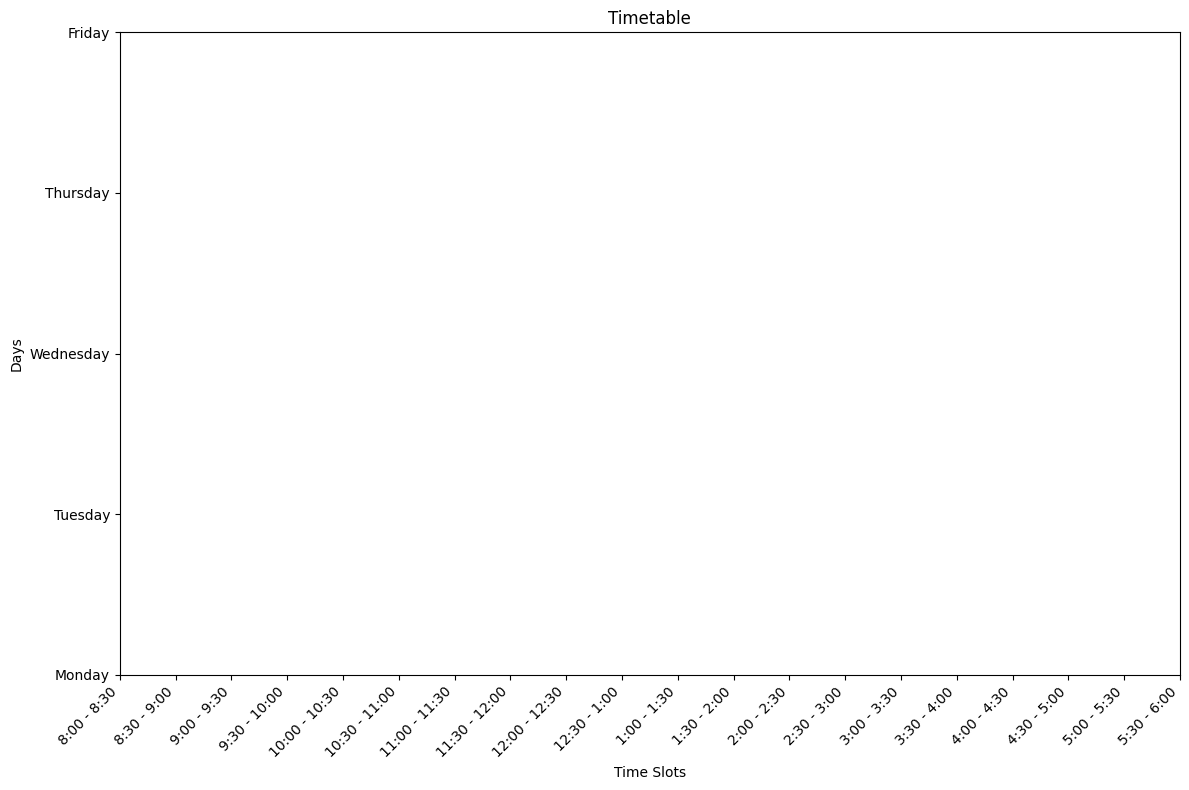

In [2]:
import random
import matplotlib.pyplot as plt

# Data classes
class Course:
    def __init__(self, id, name, is_lab):
        self.id = id
        self.name = name
        self.is_lab = is_lab

class Section:
    def __init__(self, id, name, strength):
        self.id = id
        self.name = name
        self.strength = strength

class Professor:
    def __init__(self, id, name, max_courses):
        self.id = id
        self.name = name
        self.max_courses = max_courses

class Room:
    def __init__(self, id, name, capacity):
        self.id = id
        self.name = name
        self.capacity = capacity

# Encoding and decoding functions
def encode_chromosome(lectures):
    binary_string = ''
    for lecture in lectures:
        binary_string += format(lecture['course_id'], '08b')
        binary_string += format(lecture['prof_id'], '08b')
        binary_string += format(lecture['room_id'], '08b')
        binary_string += format(lecture['section_id'], '08b')
        binary_string += format(lecture['day'], '03b')
        binary_string += format(lecture['time_slot'], '05b')
    return binary_string

def decode_chromosome(binary_string):
    lectures = []
    n = 40  # Number of bits per lecture
    for i in range(0, len(binary_string), n):
        segment = binary_string[i:i+n]
        course_id = int(segment[0:8], 2)
        prof_id = int(segment[8:16], 2)
        room_id = int(segment[16:24], 2)
        section_id = int(segment[24:32], 2)
        day = int(segment[32:35], 2)
        time_slot = int(segment[35:40], 2)
        lectures.append({'course_id': course_id, 'prof_id': prof_id, 'room_id': room_id, 'section_id': section_id, 'day': day, 'time_slot': time_slot})
    return lectures

# Genetic algorithm core functions
def generate_initial_population(size, num_lectures, num_courses, num_professors, num_rooms, num_sections):
    population = []
    for _ in range(size):
        lectures = [{
            'course_id': random.randint(1, num_courses),
            'prof_id': random.randint(1, num_professors),
            'room_id': random.randint(1, num_rooms),
            'section_id': random.randint(1, num_sections),
            'day': random.randint(0, 4),
            'time_slot': random.randint(0, 31)
        } for _ in range(num_lectures)]
        chromosome = encode_chromosome(lectures)
        population.append(chromosome)
    return population

def fitness(chromosome, professors, rooms, courses, sections):
    lectures = decode_chromosome(chromosome)
    penalty = 0
    professor_times = {}
    room_times = {}
    section_times = {}
    professor_courses = {}
    section_course_count = {}

    for lecture in lectures:
        prof_id = lecture['prof_id']
        room_id = lecture['room_id']
        course_id = lecture['course_id']
        section_id = lecture['section_id']
        day = lecture['day']
        time_slot = lecture['time_slot']

        if prof_id not in professor_times:
            professor_times[prof_id] = []
            professor_courses[prof_id] = set()
        if room_id not in room_times:
            room_times[room_id] = []
        if section_id not in section_times:
            section_times[section_id] = []
            section_course_count[section_id] = set()

        room_capacity = next((room.capacity for room in rooms if room.id == room_id), None)
        section_strength = next((section.strength for section in sections if section.id == section_id), None)
        if room_capacity is None or section_strength is None or room_capacity < section_strength:
            penalty += 5

        time_key = (day, time_slot)
        if time_key in professor_times[prof_id]:
            penalty += 10
        else:
            professor_times[prof_id].append(time_key)

        if time_key in room_times[room_id]:
            penalty += 10
        else:
            room_times[room_id].append(time_key)

        if time_key in section_times[section_id]:
            penalty += 10
        else:
            section_times[section_id].append(time_key)

        professor_courses[prof_id].add(course_id)
        if len(professor_courses[prof_id]) > 3:
            penalty += 5

        section_course_count[section_id].add(course_id)
        if len(section_course_count[section_id]) > 5:
            penalty += 5

        course = next((course for course in courses if course.id == course_id), None)
        if course and course.is_lab and (day, time_slot + 1) not in [(l['day'], l['time_slot']) for l in lectures if l['prof_id'] == prof_id]:
            penalty += 5

    return -penalty  # Higher penalty means worse fitness

def crossover(parent1, parent2):
    point = random.randint(0, len(parent1) - 1)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def mutate(chromosome, mutation_rate=0.01):
    chromosome = list(chromosome)
    for i in range(len(chromosome)):
        if random.random() < mutation_rate:
            chromosome[i] = '1' if chromosome[i] == '0' else '0'
    return ''.join(chromosome)

def genetic_algorithm(population, generations, professors, rooms, courses, sections, tournament_size=5, mutation_rate=0.01):
    for generation in range(generations):
        new_population = []
        while len(new_population) < len(population):
            if len(population) < tournament_size:
                print("Insufficient population for tournament selection; resizing tournament.")
                tournament_size = max(2, len(population))  # Ensure there's at least a minimum for selection
            parent1 = tournament_selection(population, tournament_size)
            parent2 = tournament_selection(population, tournament_size)

            # Crossover
            child1, child2 = crossover(parent1, parent2)

            # Mutation
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)

            new_population.extend([child1, child2])

        if not new_population:
            print("No viable new population was generated.")
            break  # Break out of the loop if no new population

        population = new_population

        if population:
            best_fitness = min((fitness(individual, professors, rooms, courses, sections) for individual in population), default='No fitness data')
            print(f"Generation {generation + 1}: Best Fitness = {best_fitness}")
        else:
            print("Empty population; ending simulation.")
            break

    if not population:
        return "No solution found", []

    best_solution = min(population, key=lambda x: fitness(x, professors, rooms, courses, sections))
    return best_solution, decode_chromosome(best_solution)

def tournament_selection(population, tournament_size):
    tournament = random.sample(population, tournament_size)
    best_individual = min(tournament, key=lambda x: fitness(x, professors, rooms, courses, sections))
    return best_individual

def plot_timetable(decoded_timetable, courses, professors, rooms, sections):
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    time_slots = ['8:00 - 8:30', '8:30 - 9:00', '9:00 - 9:30', '9:30 - 10:00', '10:00 - 10:30', '10:30 - 11:00',
                  '11:00 - 11:30', '11:30 - 12:00', '12:00 - 12:30', '12:30 - 1:00', '1:00 - 1:30', '1:30 - 2:00',
                  '2:00 - 2:30', '2:30 - 3:00', '3:00 - 3:30', '3:30 - 4:00', '4:00 - 4:30', '4:30 - 5:00', '5:00 - 5:30',
                  '5:30 - 6:00']

    timetable = [[None for _ in range(len(time_slots))] for _ in range(len(days))]

    for entry in decoded_timetable:
        day = entry['day']
        time_slot = entry['time_slot']

        course_id = entry['course_id']
        prof_id = entry['prof_id']
        room_id = entry['room_id']
        section_id = entry['section_id']

        # Check if the course, professor, room, and section indices are within bounds
        if 0 <= course_id - 1 < len(courses) and 0 <= prof_id - 1 < len(professors) \
                and 0 <= room_id - 1 < len(rooms) and 0 <= section_id - 1 < len(sections):
            course_name = courses[course_id - 1].name
            prof_name = professors[prof_id - 1].name
            room_name = rooms[room_id - 1].name
            section_name = sections[section_id - 1].name

            lecture_info = f"{course_name}\nProf: {prof_name}\nRoom: {room_name}\nSection: {section_name}"

            timetable[day][time_slot] = lecture_info

    fig, ax = plt.subplots(figsize=(12, 8))  # Increase the size of the plot
    ax.set_title("Timetable")
    ax.set_xlabel("Time Slots")
    ax.set_ylabel("Days")

    ax.set_xticks(range(len(time_slots)))
    ax.set_xticklabels(time_slots, rotation=45, ha='right')

    ax.set_yticks(range(len(days)))
    ax.set_yticklabels(days)

    for i in range(len(days)):
        for j in range(len(time_slots)):
            if timetable[i][j]:
                ax.text(j, i, timetable[i][j], ha='center', va='center')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


professors = [Professor(1, "Dr. Smith", 3), Professor(2, "Dr. Johnson", 3)]
rooms = [Room(1, "101", 60), Room(2, "102", 120)]
courses = [Course(1, "Math", False), Course(2, "Physics", True)]
sections = [Section(1, "A", 50), Section(2, "B", 100)]

# Generate initial population and run genetic algorithm
population = generate_initial_population(50, 10, len(courses), len(professors), len(rooms), len(sections))
generations = 100
best_timetable, decoded_timetable = genetic_algorithm(population, generations, professors, rooms, courses, sections, 5, 0.01)

# Decode and print the best timetable found
print("Best timetable found:")
for entry in decoded_timetable:
    print(entry)

# Plot the timetable
plot_timetable(decoded_timetable, courses, professors, rooms, sections)
